In [1]:
import tensorflow.keras as keras
import tensorflow.keras.layers as KL
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras

%load_ext autoreload
%autoreload 2

%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

sys.path.append('..')

In [2]:
IMG_SIZE = 64
num_of_pictures = 1000

In [3]:
# THIS IS GRAYSCALE LOADING. TO LOAD RGB CHECK LOAD_DATASET JUPYTER NOTEBOOK


mypath = "./noise_generation/grayscale"
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

 

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
original_images = np.empty([num_of_pictures,IMG_SIZE,IMG_SIZE,1])
noised_images = np.empty([num_of_pictures,IMG_SIZE,IMG_SIZE,1])

 

iteration = 0
countOdd = 0
countEven = 0

for q in onlyfiles[:num_of_pictures]:
    name = mypath+"/"+q
    oi = cv2.imread(name,cv2.IMREAD_GRAYSCALE)#image.img_to_array(image.load_img(name, target_size=(IMG_SIZE, IMG_SIZE)))
    oi = cv2.resize(oi,(IMG_SIZE,IMG_SIZE))
    original_images[iteration] = oi[:, :, np.newaxis]/255.0
    iteration += 1

print(original_images.shape)
split = int(num_of_pictures*0.7)

train_orig = original_images[:split]
#train_noised = noised_images[:split]
                        
test_orig = original_images[split:]
#test_noised = noised_images[split:]


noise_factor = 0.1
train_noised = train_orig + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_orig.shape) 
test_noised = test_orig + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_orig.shape) 

train_noised = np.clip(train_noised, 0., 1.)
test_noised = np.clip(test_noised, 0., 1.)



(1000, 64, 64, 1)


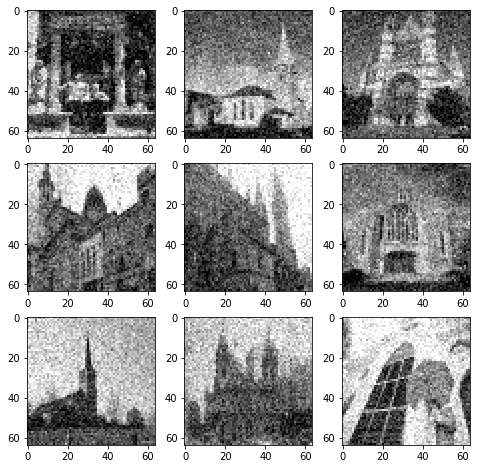

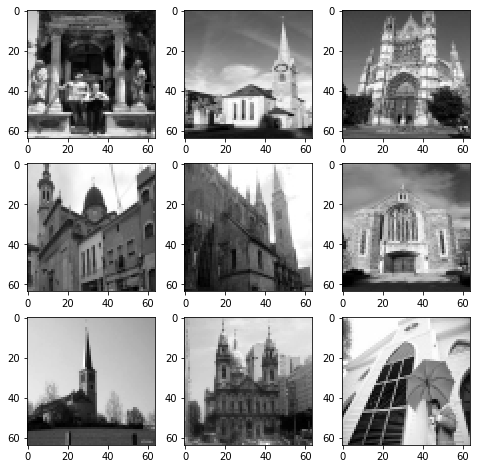

In [4]:
# DISPLAY SOME NOISED IMAGES TO SEE HOW STRING IT IS. NOISE_FACTOR=0.1 IS MAX VALUE THAT THIS MODEL CAN HANDLE

imgs = train_noised[:9]
_, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
plt.gray()
for img, ax in zip(imgs, axs):
    ax.imshow(img[:,:,0])
plt.show()  

imgs = train_orig[:9]
_, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img[:,:,0])
plt.show()

In [7]:
#TAKES ABOUT 30 MINUTES TO COMPLETE. FINAL LOSS SHOULD BE AROUND 0.0026 ON VALIDATION DATA


input_img = Input(shape=(64, 64, 1))

d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
x = BatchNormalization()(x)
d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(d2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (2, 2), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)


x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = concatenate([x,d1,d2])


decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=keras.optimizers.Adam(lr=0.003), loss='mse')


autoencoder.fit(train_noised, train_orig,
                epochs=30,
                batch_size=20,
                shuffle=True,
                validation_data=(test_noised, test_orig),
                )

Train on 700 samples, validate on 300 samples
Epoch 1/30
700/700 [==============================] - 83s 119ms/sample - loss: 0.0194 - val_loss: 0.0287
Epoch 2/30
 60/700 [=>............................] - ETA: 56s - loss: 0.0048

KeyboardInterrupt: 

224


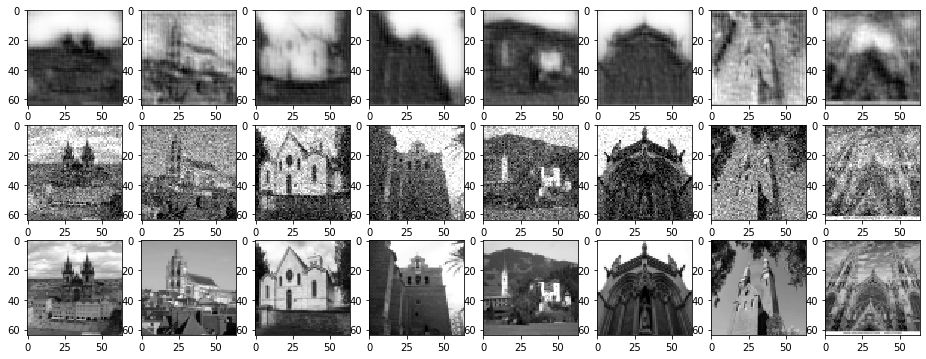

In [8]:
# FIRST ROW IS DENOISED
# SECOND ROW IS DEFAULT NOISED
# THIRD ROW IS ORIGINAL


count = 8
start = np.random.randint(0, num_of_pictures*0.3 - count)

print(start)
imgs = test_noised[start:start+count]
imgs = np.concatenate((imgs, test_noised[start:start+count], test_orig[start:start+count]))
_, axs = plt.subplots(3, count, figsize=(16, 6))

axs = axs.flatten()
i = 0
for img, ax in zip(imgs, axs):
    if (i < count):
        p_img = autoencoder.predict(img[np.newaxis,:,:,:])[0,:,:,:]
        ax.imshow(p_img[:,:,0])
    else:
        ax.imshow(img[:,:,0])
    i+=1
plt.show()   


#this model is not fully trained in this notebook -->